In [1]:
%matplotlib inline

In [11]:
import os
from keras.datasets.cifar10 import load_batch
import numpy as np
import matplotlib.pyplot as plt

https://arxiv.org/abs/1608.06993

In [4]:
def load_data():
    path = 'cifar-10-batches-py'
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(path, 'data_batch_' + str(i)))
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    x_test, y_test = load_batch(os.path.join(path, 'test_batch'))
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [9]:
(x_train, y_train), (x_test, y_test) = load_data()

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

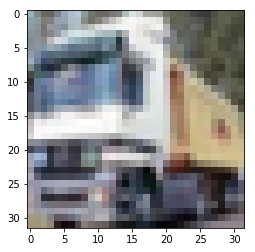

In [12]:
plt.imshow(x_train[1])

In [13]:
x_train = x_train/255.
x_test = x_test/255.

## DenseNet

In [46]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import backend as K
K.set_image_data_format('channels_last')

In [38]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(axis=-1)(x)
def relu_bn(x): return relu(bn(x))

In [36]:
def conv(x, nf, sz, wd, p):
    x = Conv2D(nf, (sz, sz), kernel_initializer='he_uniform', padding='same', 
                          kernel_regularizer=l2(wd))(x)
    return dropout(x,p)

In [48]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

In [49]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = concatenate([x,b], axis=-1)
    return x

In [33]:
def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

In [51]:
def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=1.0, p=None, wd=0, activation='softmax'):
    
    assert activation == 'softmax' or activation == 'sigmoid'
    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation=activation, kernel_regularizer=l2(wd))(x)

In [57]:
input_shape = (32,32,3)
img_input = Input(shape=input_shape)
x = create_dense_net(10, img_input, depth=100, nb_filter=16, compression=0.5, 
                     bottleneck=True, p=0.2, wd=1e-4)
model = Model(img_input, x)
model.compile(loss='sparse_categorical_crossentropy', 
      optimizer=SGD(0.1, 0.9, nesterov=True), metrics=["accuracy"])

In [58]:
K.set_value(model.optimizer.lr, 0.1)
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 639s - loss: 1.9671 - acc: 0.4901 - val_loss: 2.5966 - val_acc: 0.4421
Epoch 2/20
50000/50000 [==============================] - 591s - loss: 1.4376 - acc: 0.6563 - val_loss: 3.5183 - val_acc: 0.3897
Epoch 3/20
50000/50000 [==============================] - 590s - loss: 1.2022 - acc: 0.7213 - val_loss: 3.6211 - val_acc: 0.3654
Epoch 4/20
50000/50000 [==============================] - 589s - loss: 1.0450 - acc: 0.7594 - val_loss: 1.7910 - val_acc: 0.5913
Epoch 5/20
50000/50000 [==============================] - 590s - loss: 0.9473 - acc: 0.7858 - val_loss: 1.5331 - val_acc: 0.6369
Epoch 6/20
50000/50000 [==============================] - 590s - loss: 0.8797 - acc: 0.8033 - val_loss: 2.2582 - val_acc: 0.5606
Epoch 7/20
50000/50000 [==============================] - 589s - loss: 0.8285 - acc: 0.8163 - val_loss: 1.3882 - val_acc: 0.6466
Epoch 8/20
50000/50000 [=======================

In [59]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 589s - loss: 0.5530 - acc: 0.9130 - val_loss: 0.5933 - val_acc: 0.8984
Epoch 2/20
50000/50000 [==============================] - 589s - loss: 0.4878 - acc: 0.9318 - val_loss: 0.5744 - val_acc: 0.9032
Epoch 3/20
50000/50000 [==============================] - 589s - loss: 0.4617 - acc: 0.9369 - val_loss: 0.6105 - val_acc: 0.8967
Epoch 4/20
50000/50000 [==============================] - 590s - loss: 0.4412 - acc: 0.9411 - val_loss: 0.5741 - val_acc: 0.9050
Epoch 5/20
50000/50000 [==============================] - 589s - loss: 0.4263 - acc: 0.9441 - val_loss: 0.6098 - val_acc: 0.8946
Epoch 6/20
50000/50000 [==============================] - 589s - loss: 0.4111 - acc: 0.9471 - val_loss: 0.5881 - val_acc: 0.9005
Epoch 7/20
50000/50000 [==============================] - 589s - loss: 0.3957 - acc: 0.9498 - val_loss: 0.5400 - val_acc: 0.9091
Epoch 8/20
50000/50000 [=======================

In [60]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 589s - loss: 0.2635 - acc: 0.9750 - val_loss: 0.5370 - val_acc: 0.9101
Epoch 2/20
50000/50000 [==============================] - 590s - loss: 0.2550 - acc: 0.9788 - val_loss: 0.5278 - val_acc: 0.9107
Epoch 3/20
50000/50000 [==============================] - 590s - loss: 0.2498 - acc: 0.9795 - val_loss: 0.5221 - val_acc: 0.9111
Epoch 4/20
50000/50000 [==============================] - 589s - loss: 0.2469 - acc: 0.9808 - val_loss: 0.5218 - val_acc: 0.9125
Epoch 5/20
50000/50000 [==============================] - 590s - loss: 0.2444 - acc: 0.9811 - val_loss: 0.5249 - val_acc: 0.9106
Epoch 6/20
50000/50000 [==============================] - 590s - loss: 0.2425 - acc: 0.9816 - val_loss: 0.5215 - val_acc: 0.9120
Epoch 7/20
50000/50000 [==============================] - 590s - loss: 0.2417 - acc: 0.9822 - val_loss: 0.5160 - val_acc: 0.9142
Epoch 8/20
50000/50000 [=======================

In [61]:
model.save_weights('densenet.h5')